Diffusion solver for heterogenous one-dimensional slabs

In [31]:
using Plots,LinearAlgebra
using SparseArrays, SuiteSparse, LinearSolve
plotlyjs();

Function for solving diffusion equation using a fixed source

In [3]:
function slab_diffusion_solver(f,bc,N;graph=false)
    
    D,Σr,Q=f
    β1,β2,J1,J2=bc
    widths,NΔx=N
    
    Δx=Float64[]
    for i=1:length(widths)
        Δx=[Δx;ones(NΔx[i]).*widths[i]/NΔx[i]]
    end
    N=sum(NΔx) 
    x=[sum(Δx[1:i])-*(Δx[i]/2) for i=1:N]
    A=zeros(N,N);
    b=zeros(N);
    kl=2*D(x[1])*D(x[2])/((Δx[1]*D(x[2]))+(Δx[2]*D(x[1])))
    kβ1=2*D(x[1])*(1-β1)/((4*D(x[1])*(1+β1))+(Δx[1]*(1-β1)))
    A[1,1:2]=[kl+kβ1+(Σr(x[1])*Δx[1]),-kl]
    b[1]=Q(x[1])*Δx[1]
    for i=2:N-1
        kim1=2*D(x[i])*D(x[i-1])/((Δx[i-1]*D(x[i]))+(Δx[i]*D(x[i-1])))
        kip1=2*D(x[i])*D(x[i+1])/((Δx[i+1]*D(x[i]))+(Δx[i]*D(x[i+1])))
        A[i,i-1:i+1]=[-kim1,kim1+kip1+Σr(x[i])*Δx[i],-kip1]
        b[i]=Q(x[i])*Δx[i]
    end
    kr=2*D(x[N])*D(x[N-1])/((Δx[N]*D(x[N-1]))+(Δx[N-1]*D(x[N])))
    kβ2=2*D(x[N])*(1-β2)/((4*D(x[N])*(1+β2))+(Δx[1]*(1-β2)))
    A[N,N-1:N]=[-kr,kr+kβ2+(Σr(x[N])*Δx[N])]
    b[N]=Q(x[N])*Δx[N];
    if J1!=0 || J2!=0
        b[1]+= 8*D(x[1])*J1*(1+β1)/(4*D(x[1])*(1+β1)+Δx[1]*(1-β1))
        b[N]+= 8*D(x[N])*J2/((4*D(x[N])*Δx[N])+(Δx[N]^2))
    end
    
    ϕ=A\b
    if graph
        fig=plot(x,ϕ,label="ϕ")
        display(fig)
    end
    
    return ϕ
end ;

Sample roblem description for above function: Reed's Cell

In [4]:
#Defining Geometry
function geometry(x)
    Region_1= x>0 && x<2
    Region_2= x>2 && x<3
    Region_3= x>3 && x<5    
    Region_4= x>5 && x<6    
    Region_5= x>6 && x<8
    return [Region_1,Region_2,Region_3,Region_4,Region_5]
end

#assigning material properties to the geometry
Σt(x)=sum(geometry(x).*[50.0,5.0,1e-6,1.0,1.0])/sum(geometry(x)); #total cross section
Σr(x)=sum(geometry(x).*[50.0,5.0,0,0.1,0.1])/sum(geometry(x)); #removal cross section
Q(x)=sum(geometry(x).*[50.0,0.0,0.0,1.0,0.0])/sum(geometry(x)); #source term
D(x)=1/3/Σt(x); #Diffusion Coefficient

f=D,Σr,Q 

#Albedo Boundary Conditions
β1=1   #Reflective
β2=0   #Vacuum

#Partial currents
J1=0   #left
J2=0 ; #right

bc=β1,β2,J1,J2 ;

widths=[2,1,2,1,2]
NΔx=[5,5,5,5,5]*20

N=widths,NΔx ;

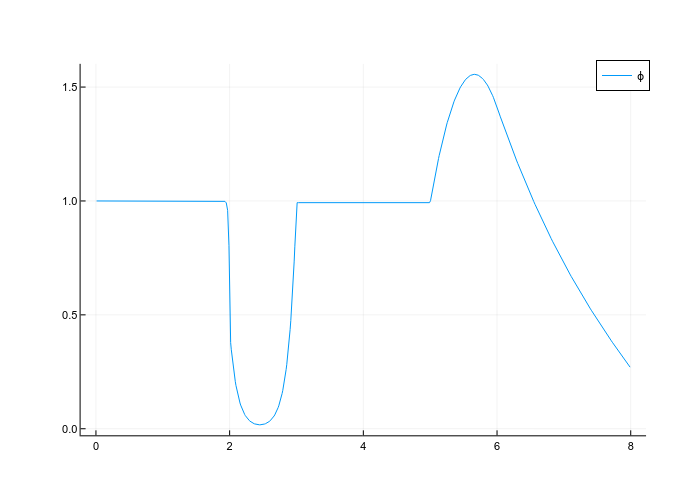

In [5]:
ϕ=slab_diffusion_solver(f,bc,N,graph=true);

Homogenous Medium with partial current

In [32]:
Σr(x)=0.25 #removal cross section
Q(x)=0 #source term
D(x)=1 #Difusion Coefficient

f=D,Σr,Q ;

#Albedo Boundary Conditions
β1=1   #Reflective
β2=0   #Vacuum

#Partial currents
J1=0.25   #left
J2=0 ; #right

bc=β1,β2,J1,J2 ;

N=[10],[1000] ;

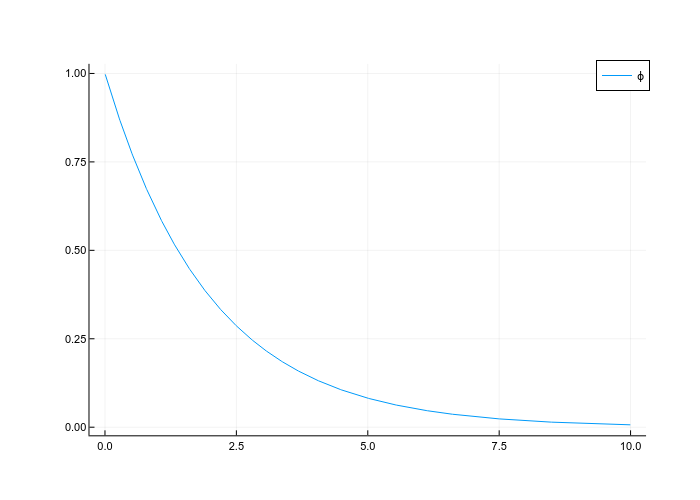

In [7]:
ϕ1=slab_diffusion_solver(f,bc,N,graph=true);

Approaching diffusion equation with simplistic finite difference method

In [8]:
function twopointbvp(N,p,q,r,b1,b2)
     
    c1,k1,a,g1=b1
    c2,k2,b,g2=b2
    
    n = N - 1 + c1 + c2          
    A = zeros( n, n )
    B = zeros(n)
    h = ( b - a ) / N
    x = [ a + i*h for i=0:N ][ 2 - c1 : N + c2 ]
    y = zeros( N + 1 )
    
    if c1 == 1
        A[ 1, 1 : 3 ] = [ 2 * h * k1 - 3, 4, -1]
        B[1] = 2 * h * g1
    end    
    if c1 == 0
        A[ 1, 1 : 2 ]=[ 2 + h^2 * q( x[1] ), 0.5 * h * p( x[1] ) - 1 ]
        B[1] = -h^2 *r( x[1] ) + ( 1 + 0.5 * h * p( x[1] ) ) * g1
        y[1] = g1
    end
    if c2 == 1
        A[ n, n-2 : n ] = [ 1, -4, 3 + 2 * h * k2 ]
        B[ n ] = 2 * h * g2
    end
    if c2 == 0
        A[ n , n-1 : n ] = [ -( 1 + 0.5 * h * p( x[n] ) ),
                              h^2 * q( x[n] ) + 2 ]
        B[n] = - h^2 * r( x[n] ) + ( 1 - 0.5 * h * p( x[n] ) ) * g2
        y[N+1] = g2
    end
        
    for i=2:n-1
        A[ i, i-1 : i+1 ]=[ -( 1 + 0.5 * h * p( x[i] ) ),
                           q( x[i] ) * h^2 + 2, 
                           0.5 * h * p( x[i] ) - 1 ]
        B[i] = -h^2 * r( x[i] )
    end
    
    y[ 2-c1 : N+c2 ] = A\B  
    x = [ a + i*h for i=0:N ]
    #display(plot(x,y))
    return x,y
end

twopointbvp (generic function with 1 method)

In [9]:
p(x)=0
q(x)=Σr(x)/D(x)
r(x)=-Q(x)/D(x)
b1=1,0,0,-0.5
b2=1,1/4,10,0;

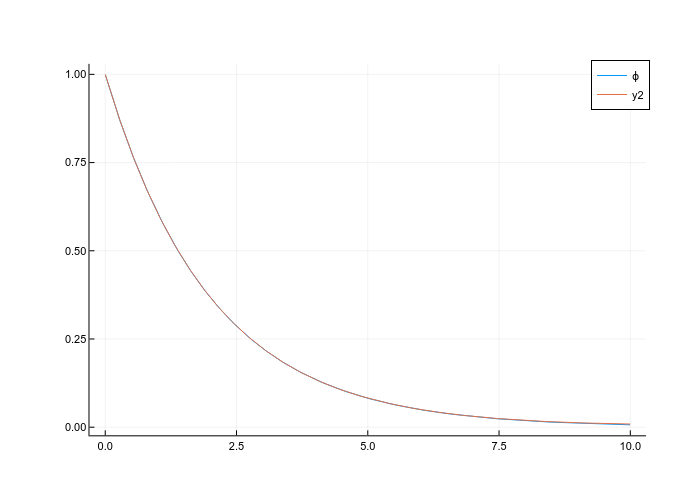

In [10]:
x,ϕ2=twopointbvp(1000,p,q,r,b1,b2);
plot!(x,ϕ2)

Both control volume approach and finite difference method solve homogenous problems accurately. 
However, finite difference method can not handle heterogenity in a straight forward manner.
The problem below illustrates the point

In [11]:
Σr(x)=0.25 #removal cross section
Q(x)=0 #source term
D(x)=1*(x<=2)+2*(x>2) #Diffusion Coefficient

f=D,Σr,Q ;

#Albedo Boundary Conditions
β1=1   #Reflective
β2=0   #Vacuum

#Partial currents
J1=0.25   #left
J2=0 ; #right

bc=β1,β2,J1,J2 ;

N=[2,8],[200,800]

([2, 8], [200, 800])

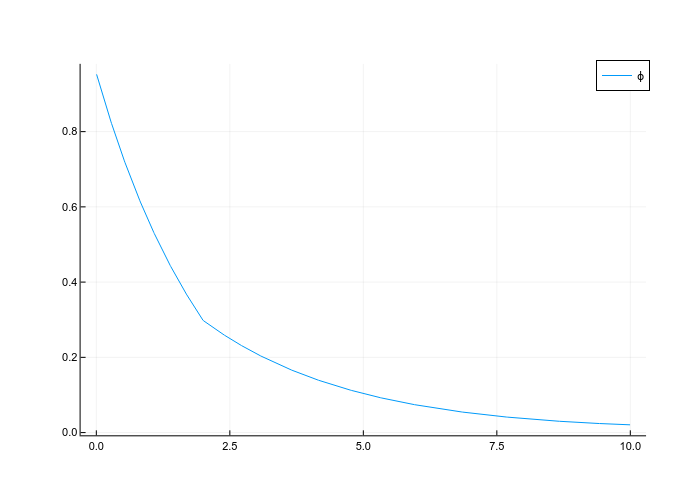

In [12]:
ϕ=slab_diffusion_solver(f,bc,N,graph=true);

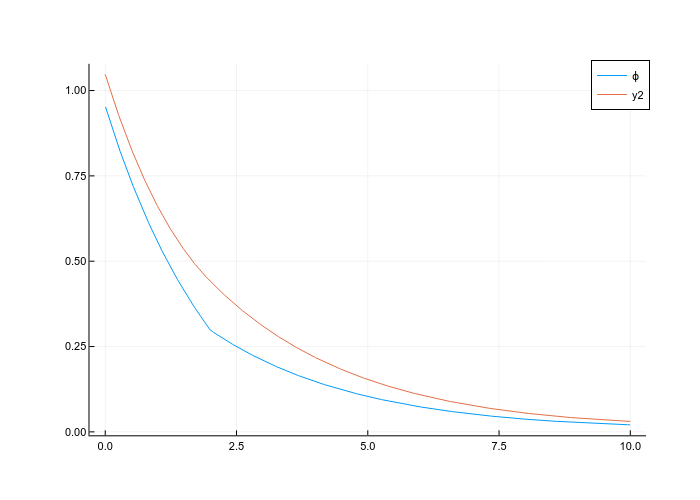

In [13]:
p(x)=0
q(x)=Σr(x)/D(x)
r(x)=-Q(x)/D(x)
b1=1,0,0,-0.5
b2=1,1/4,10,0
x,ϕ2=twopointbvp(1000,p,q,r,b1,b2);
plot!(x,ϕ2)

The function below solves multigroup diffusion equation in 1D slabs and find its k-eigenvalue, the multiplication factor of the system. It solves all the groups directly in a single linear system.

In [14]:
function mg1D_diffusion_k_solver(f,bc,n)
    
    D,Σr,Σso,νΣf,χ=f
    β1,β2=bc
    widths,NΔx=n
    
    Δx=Float64[]
    for i=1:length(widths)
        Δx=[Δx;ones(NΔx[i]).*widths[i]/NΔx[i]]
    end
    N=sum(NΔx) 
    x=[sum(Δx[1:i])-*(Δx[i]/2) for i=1:N]
    Groups=length(χ(0));


    A=zeros(N*Groups,N*Groups)

    for group=1:Groups
        kl=2*D(x[1])[group]*D(x[2])[group]/((Δx[1]*D(x[2])[group])+(Δx[2]*D(x[1])[group]))
        kβ1=2*D(x[1])[group]*(1-β1)/((4*D(x[1])[group]*(1+β1))+(Δx[1]*(1-β1)))
        A[(group-1)*N+1,(group-1)*N+1:(group-1)*N+2]=[kl+kβ1+(Σr(x[1])[group]*Δx[1]),-kl]
        for i=2:N-1
            kim1=2*D(x[i])[group]*D(x[i-1])[group]/((Δx[i-1]*D(x[i])[group])+(Δx[i]*D(x[i-1])[group]))
            kip1=2*D(x[i])[group]*D(x[i+1])[group]/((Δx[i+1]*D(x[i])[group])+(Δx[i]*D(x[i+1])[group]))
            A[(group-1)*N+i,(group-1)*N+i-1:(group-1)*N+i+1]=[-kim1,kim1+kip1+Σr(x[i])[group]*Δx[i],-kip1]
        end
        kr=2*D(x[N])[group]*D(x[N-1])[group]/((Δx[N]*D(x[N-1])[group])+(Δx[N-1]*D(x[N])[group]))
        kβ2=2*D(x[N])[group]*(1-β2)/((4*D(x[N])[group]*(1+β2))+(Δx[1]*(1-β2)))
        A[(group-1)*N+N,(group-1)*N+N-1:(group-1)*N+N]=[-kr,kr+kβ2+(Σr(x[N])[group]*Δx[N])]
        for i=1:N
            for gr=1:Groups
                A[(group-1)*N+i,(gr-1)*N+i]-=Σso(x[i])[group,gr]*Δx[i]
            end
        end
    end
    

    A,ipiv,info=LAPACK.getrf!(A);


    Kp=1
    error=1
    Φ=zeros(N*Groups).+0.0001
    F=zeros(N*Groups)
    Fp=zeros(N*Groups);

    νΣf_i=map(νΣf,x)
    χ_i=map(χ,x);
    
    ind=1
    for group=1:Groups
        for i=1:N
            for gr=1:Groups
                Fp[ind]+=νΣf_i[i][gr]*Φ[(gr-1)*N+i]/Kp.*Δx[i].*χ_i[i][group]
            end
            ind+=1
        end
    end
    while error > 1e-8
        Φ=copy(Fp)
        LAPACK.getrs!('N',A,ipiv,Φ)

        ind=1
        F*=0
        for group=1:Groups
            for i=1:N
                for gr=1:Groups
                    F[ind]+=νΣf_i[i][gr]*Φ[(gr-1)*N+i].*Δx[i].*χ_i[i][group]
                end
                ind+=1
            end
        end
        
        K=sum(F)/sum(Fp)
        Fp=copy(F./K)
        error=abs(Kp-K)
        Kp=K
    end
    return Kp,Φ
end

mg1D_diffusion_k_solver (generic function with 1 method)

The function below solves the same problem by solving each of the group fluxes seperatively in an iterative manner.

In [15]:
function mg1D_diffusion_k_solver_lc(f,bc,N)
    
    D,Σr,Σso,νΣf,χ=f
    β1,β2=bc
    widths,NΔx=N
    
    Δx=Float64[]
    for i=1:length(widths)
        Δx=[Δx;ones(NΔx[i]).*widths[i]/NΔx[i]]
    end
    N=sum(NΔx) 
    x=[sum(Δx[1:i])-*(Δx[i]/2) for i=1:N]
    Groups=length(χ(0));


    A=[zeros(N,N) for i=1:Groups];

    for group=1:Groups
        kl=2*D(x[1])[group]*D(x[2])[group]/((Δx[1]*D(x[2])[group])+(Δx[2]*D(x[1])[group]))
        kβ1=2*D(x[1])[group]*(1-β1)/((4*D(x[1])[group]*(1+β1))+(Δx[1]*(1-β1)))
        A[group][1,1:2]=[kl+kβ1+(Σr(x[1])[group]*Δx[1]),-kl]
        for i=2:N-1
            kim1=2*D(x[i])[group]*D(x[i-1])[group]/((Δx[i-1]*D(x[i])[group])+(Δx[i]*D(x[i-1])[group]))
            kip1=2*D(x[i])[group]*D(x[i+1])[group]/((Δx[i+1]*D(x[i])[group])+(Δx[i]*D(x[i+1])[group]))
            A[group][i,i-1:i+1]=[-kim1,kim1+kip1+Σr(x[i])[group]*Δx[i],-kip1]
        end
        kr=2*D(x[N])[group]*D(x[N-1])[group]/((Δx[N]*D(x[N-1])[group])+(Δx[N-1]*D(x[N])[group]))
        kβ2=2*D(x[N])[group]*(1-β2)/((4*D(x[N])[group]*(1+β2))+(Δx[1]*(1-β2)))
        A[group][N,N-1:N]=[-kr,kr+kβ2+(Σr(x[N])[group]*Δx[N])]
    end

    ipiv=zeros(Int,Groups,N);
    info=zeros(Int,Groups);

    for group=1:Groups
        A[group],ipiv[group,:],info[group]=LAPACK.getrf!(A[group]);
    end

    Kp=1
    error=1
    Φ=[ones(N) for group=1:Groups]
    Φp=ones(N,Groups)
    Q=zeros(N,Groups)
    F=copy(Q)
    Fp=copy(Q);

    νΣf_i=map(νΣf,x)
    Σso_i=map(Σso,x)
    χ_i=map(χ,x);

    for i=1:N
        Fp[i,:]=νΣf_i[i]*Φp[i,:]/Kp.*Δx[i].*χ_i[i]
    end

    while error > 1e-12
        for i=1:N
            Q[i,:]= Fp[i,:] + Σso_i[i]*Φp[i,:]*Δx[i]
        end
        for group=1:Groups
            Φ[group]=Q[:,group]
            LAPACK.getrs!('N',A[group],ipiv[group,:],Φ[group])
            Φp[:,group]=Φ[group]
        end
        for i=1:N
            F[i,:]=νΣf_i[i]*Φp[i,:].*Δx[i].*χ_i[i]
        end
        K=sum(F)/sum(Fp)
        Fp=F./K
        error=abs(Kp-K)
        Kp=K
    end
    fig=plot(x,Φp)
    display(fig)
    return Kp,Φp
end

mg1D_diffusion_k_solver_lc (generic function with 1 method)

Sample Problems and their solutions

In [20]:
#Defining Geometry
function geometry(x)
    U235 = x>=0 && x<=0.0329074
    H2O = x>=0.0329074 && x<=9.067695
    return U235,H2O
end

#assigning material properties to the geometry
function Σt(x)
    U235,H2O=geometry(x)
    return U235* [0.650917 ; 2.13800] + H2O * [0.1106832906 ; 0.36355]
end

function Σr(x)
    U235,H2O=geometry(x)
    return U235*[0.650917 ; 0.0692] + H2O*[0.001009076 ; 1.6e-4]
end

function Σso(x)
    U235,H2O=geometry(x)
    return U235* [0 0 ; 0.0342008 0] + H2O * [0 0 ; 0.001000595707 0]
end

function νΣf(x)
    U235,H2O=geometry(x)
    return U235* [0.617209  0.11426]
end

D(x)=1/3 ./ Σt(x)
χ(x)=geometry(x)[1]*[1 ; 0]

f=D,Σr,Σso,νΣf,χ

#Albedo Boundary Conditions
β1=1   #Reflective
β2=1   #Vacuum

bc=β1,β2;

widths=[ 0.0329074, 9.034787]
NΔx=[10,40]

N=widths,NΔx ;

  1.224468 seconds (755.66 k allocations: 47.438 MiB, 2.81% gc time, 99.24% compilation time: 38% of which was recompilation)


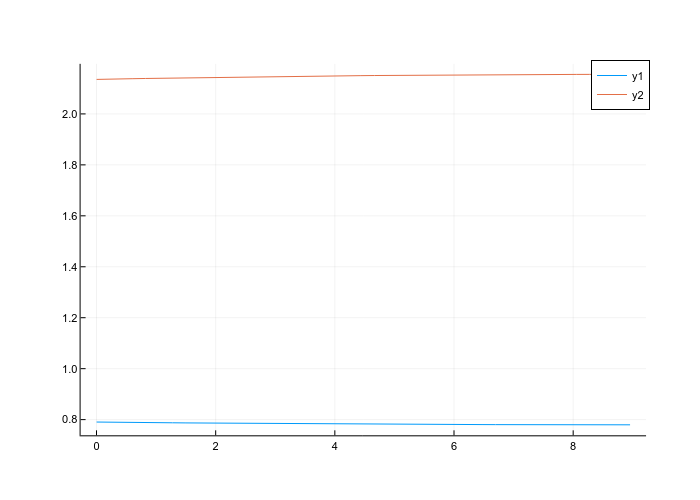

  2.268130 seconds (1.35 M allocations: 106.282 MiB, 2.93% gc time, 91.30% compilation time)


1.0005461909788809

In [21]:
@time K,Φ=mg1D_diffusion_k_solver(f,bc,N);
@time K,Φ=mg1D_diffusion_k_solver_lc(f,bc,N);
K

In [23]:
#assigning material properties
Σt(x)=[0.240 ; 0.975 ; 3.10] 

Σr(x)=[0.216 ; 0.375 ; 1.1]

Σso(x)=[0      0      0;
        0.171  0      0;
        0.033  0.275  0]

νΣf(x)= [0.018  0.15 1.8]

D(x)=1/3 ./Σt(x)
χ(x)=[0.96 ; 0.04 ; 0.0]

f=D,Σr,Σso,νΣf,χ

#Albedo Boundary Conditions
β1=1   #Reflective
β2=1   #Vacuum

bc=β1,β2;

widths=[2]
NΔx=[100]

N=widths,NΔx ;

  0.895897 seconds (563.43 k allocations: 33.212 MiB, 4.02% gc time, 98.15% compilation time: 26% of which was recompilation)


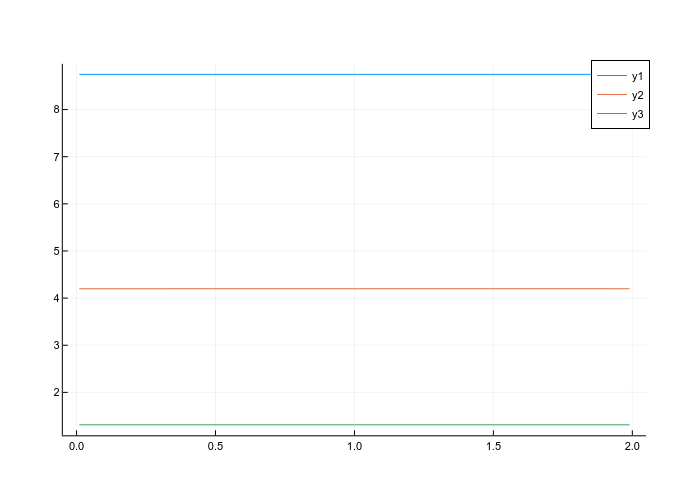

  1.282483 seconds (579.92 k allocations: 36.996 MiB, 2.78% gc time, 88.99% compilation time: 4% of which was recompilation)


1.5999999999975003

In [24]:
@time K,Φ=mg1D_diffusion_k_solver(f,bc,N);
@time K,Φ=mg1D_diffusion_k_solver_lc(f,bc,N);
K

In [25]:
#assigning material properties
Σt(x)=[0.240 ; 0.975 ; 3.10 ; 3.10 ; 0.975 ; 0.240] 

Σr(x)=[0.216 ; 0.375 ; 1.1 ; 1.1 ; 0.375 ; 0.216]

Σso(x)=[0      0      0      0      0      0     ;
        0.171  0      0      0      0      0     ;
        0.033  0.275  0      0      0      0     ;
        0      0      0      0      0.275  0.033 ;
        0      0      0      0      0      0.171 ;
        0      0      0      0      0      0     ;]

νΣf(x)= [0.018  0.15 1.8 1.8 0.15 0.018]

D(x)=1/3 ./Σt(x)
χ(x)=[0.48 ; 0.02 ; 0.0 ; 0.0 ; 0.02 ; 0.48]

f=D,Σr,Σso,νΣf,χ

#Albedo Boundary Conditions
β1=1   #Reflective
β2=1   #Vacuum

bc=β1,β2;

widths=[2]
NΔx=[100]

N=widths,NΔx ;

  1.028933 seconds (973.07 k allocations: 85.042 MiB, 5.11% gc time, 76.83% compilation time: 77% of which was recompilation)


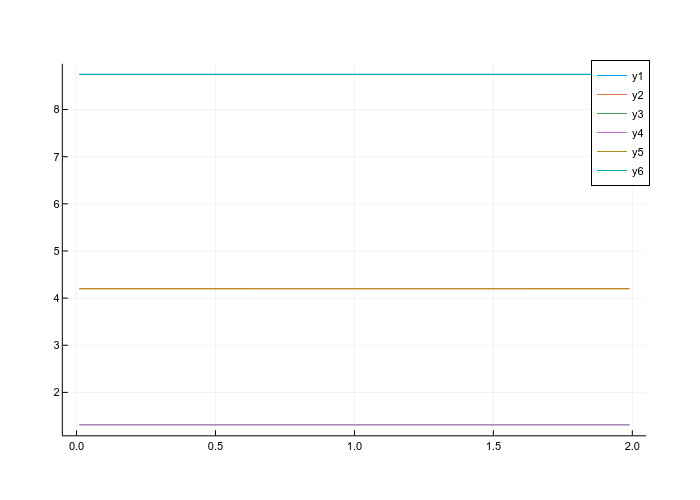

  1.232220 seconds (444.88 k allocations: 29.978 MiB, 3.45% gc time, 70.48% compilation time: 85% of which was recompilation)


1.599999999997499

In [26]:
@time K,Φ=mg1D_diffusion_k_solver(f,bc,N);
@time K,Φ=mg1D_diffusion_k_solver_lc(f,bc,N);
K

In [29]:

widths=[4.863392, 5.630757]

NΔx=[10,10]

N=widths,NΔx ;

#Defining Geometry
function geometry(x,widths=widths)
    i=0
    while x>=0
        i+=1
        x-=widths[i]

    end
    if i==1
        return true,false
    elseif i==2
        return false,true
    else
        return 0,0
    end
    
end

#assigning material properties to the geometry
function Σt(x)
    U235,H2O=geometry(x)
    return U235* [0.88721 ; 2.9727] + H2O * [0.88798 ; 2.9865]
end

function Σr(x)
    U235,H2O=geometry(x)
    return U235*[0.04829 ; 0.0544] + H2O*[0.04823 ; 0.0189]
end

function Σso(x)
    U235,H2O=geometry(x)
    return U235* [0 0.000767 ; 0.04635 0] + H2O * [0 0.000336 ; 0.04749 0]
end

function νΣf(x)
    U235,H2O=geometry(x)
    return U235* [2.09e-3  0.07391]
end

D(x)=1/3 ./Σt(x)
χ(x)=geometry(x)[1]*[1 ; 0]

f=D,Σr,Σso,νΣf,χ

#Albedo Boundary Conditions
β1=1   #Reflective
β2=0  #Vacuum

bc=β1,β2;


  0.907835 seconds (640.36 k allocations: 39.531 MiB, 3.74% gc time, 99.78% compilation time: 76% of which was recompilation)


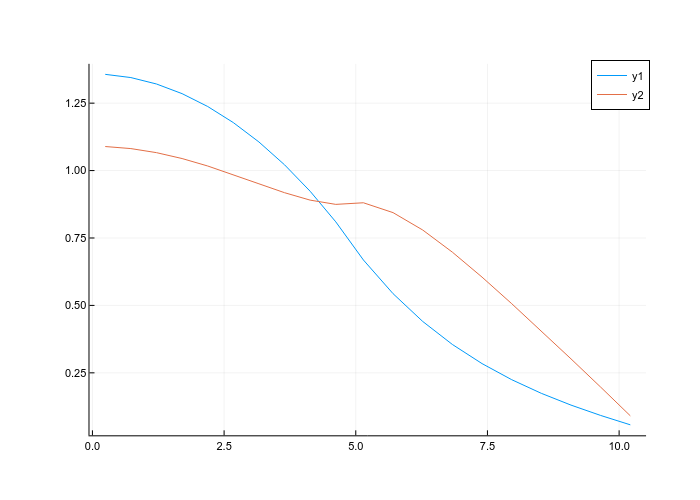

  0.852013 seconds (321.51 k allocations: 19.310 MiB, 3.26% gc time, 77.51% compilation time: 99% of which was recompilation)


0.9963595286658763

In [30]:
@time K,Φ=mg1D_diffusion_k_solver(f,bc,N);
@time K,Φ=mg1D_diffusion_k_solver_lc(f,bc,N);
K